In [1]:
%run flow_tools-Copy1.py

/opt/homebrew/Caskroom/miniforge/base/envs/flow/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from matplotlib.path import Path
from matplotlib import patches

In [3]:
folders = ['/Users/weinberz/Library/CloudStorage/Box-Box/BadIdea/Flow/20240509 - Minibinder Sensitivity/',
          '/Users/weinberz/Library/CloudStorage/Box-Box/BadIdea/Flow/20240509 - Minibinder Specificity/']

In [4]:
df = [load_data(folder, colnames = ['WellName', 'Target', 'Effector', 'Ratio', 'Replicate', 'Plate']) for folder in folders]
df = pd.concat(df)
df.Effector = df.Effector.fillna('None')

In [5]:
#remove all rows with values less than 0
df2= df.loc[(df.select_dtypes(include=['number']) > 0).all(axis='columns'), :]

#remove all rows with missing values
df2= df2.dropna()

In [6]:
#define gate for FSC-A vs SSC-A
fsc_ssc_verts = [(4e4, 1e4),
              (1e5, 2.5e4),
              (2.5e5, 1e5),
              (2.5e5, 2.5e5),
              (1e5, 2.5e5),
              (4e4, 5e4),
              (4e4, 5e4),
              (4e4, 1e4)]
fsc_ssc_gate = Path(fsc_ssc_verts)

ssc_verts = [(0, 1e4),
              (2e5, 1.8e5),
              (2.6e5, 1.8e5),
              (2.5e5, 1.3e5),
              (1.25e5, 7.5e4),
              (1e4, 0),
              (0, 1e4)]
ssc_gate = Path(ssc_verts)

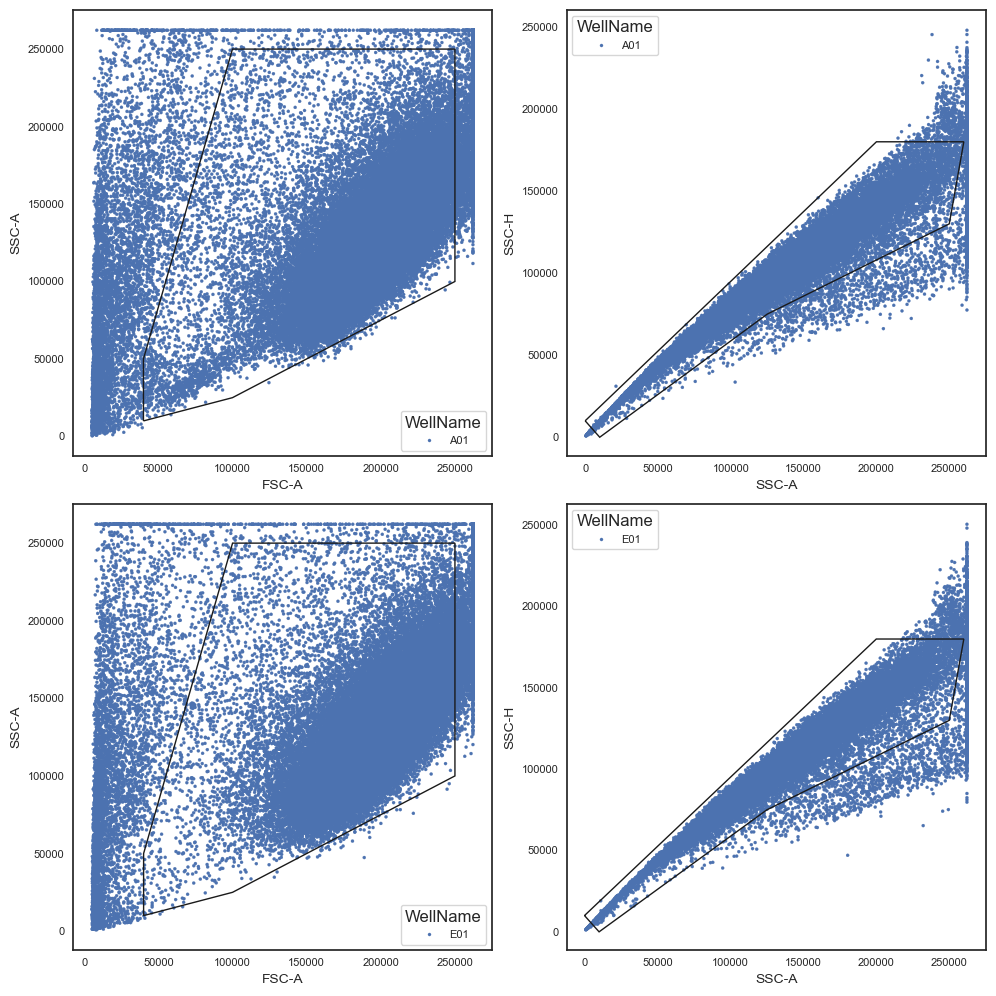

In [27]:
fig, axs = plt.subplots(2,2, figsize=[10,10])
sns.scatterplot(data=df2[(df2['WellName'].isin(['A01'])) & (df2['Plate']=='1')], x='FSC-A', y='SSC-A', marker='o', s=5, edgecolors=None, ax=axs[0,0], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['A01']) & (df2['Plate']=='1')], x='SSC-A', y='SSC-H', marker='o', s=5, edgecolors=None, ax=axs[0,1], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['E01']) & (df2['Plate']=='1')], x='FSC-A', y='SSC-A', marker='o', s=5, edgecolors=None, ax=axs[1,0], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['E01']) & (df2['Plate']=='1')], x='SSC-A', y='SSC-H', marker='o', s=5, edgecolors=None, ax=axs[1,1], hue='WellName')
patch = patches.PathPatch(fsc_ssc_gate, facecolor="None", edgecolor='k')
axs[0,0].add_patch(patch)
patch = patches.PathPatch(fsc_ssc_gate, facecolor="None", edgecolor='k')
axs[1,0].add_patch(patch)
patch = patches.PathPatch(ssc_gate, facecolor="None", edgecolor='k')
axs[0,1].add_patch(patch)
patch = patches.PathPatch(ssc_gate, facecolor="None", edgecolor='k')
axs[1,1].add_patch(patch)
plt.tight_layout()

In [7]:
#filter to gate
df2 = df2[fsc_ssc_gate.contains_points(df2[['FSC-A','SSC-A']].to_numpy())]
df2 = df2[ssc_gate.contains_points(df2[['SSC-A', 'SSC-H']].to_numpy())]
# # gate on singlets
# df2 = gate_density(df2, 0.1, x_var='SSC-A',y_var='SSC-H')

for col in df2.columns:
        if df2[col].dtype=="float32":
            df2["log"+ col]=df2[col].apply(math.log10)

<Axes: xlabel='logBV 421-A', ylabel='Density'>

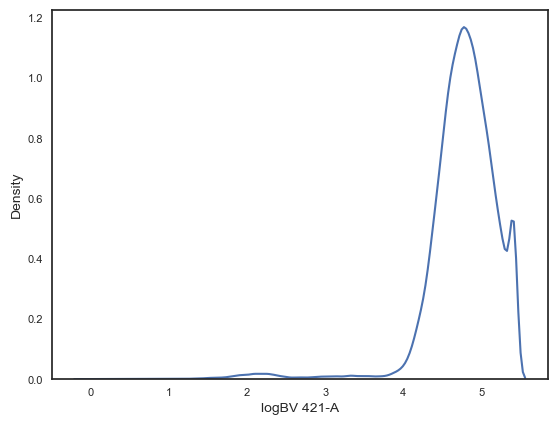

In [32]:
sns.kdeplot(df2[(df2.WellName == 'A01')]['logBV 421-A'])

In [8]:
df2['Type'] = 'Unknown'
df2.loc[df2['logBV 421-A']>=3, 'Type'] = 'Target'
df2.loc[df2['logBV 421-A']<3, 'Type'] = 'Effector'

In [9]:
df2 = df2.replace(to_replace='2224-CAR', value='P2224-CAR')
df2 = df2.replace(to_replace='EGFRn_mb-CAR', value='EGFRn-CAR')
df2 = df2.replace(to_replace='EGFRc_mb-CAR', value='EGFRc-CAR')

In [14]:
effectors = ['Untransduced','P2224-CAR', 'EGFRn-CAR', 'EGFRc-CAR']
targets = ['K562', 'EGFR-K562']
ratios = ['1:1', '1:2', '1:4', '1:8','1:16']

In [11]:
count_df = (df2.groupby(['WellName','Effector','Target','Ratio','Replicate','Plate'])['Type']
                 .agg(Effectors=(lambda x: np.sum(x == 'Effector')),
                      Targets=(lambda x: np.sum(x == 'Target')))
                 .reset_index())

In [10]:
df2.to_csv('20240509_killing_raw.csv')
count_df.to_csv('20240509_killing_counts.csv')

In [12]:
count_df['Lysis'] = np.nan
count_df['Fold Change From UnT'] = np.nan
for target in target_order:
    for Ratio in ratio_order:
        target_filter = ((count_df['Target'] == target) & 
                         (count_df['Ratio'] == Ratio))
        baseline = count_df[(count_df['Effector'] == 'Untransduced') &
                            target_filter]['Targets'].mean()
        count_df.loc[target_filter, 'Lysis'] = 100-(100*((count_df[target_filter]['Targets']/baseline)))
        unt_killing = count_df[(count_df['Effector'] == 'Untransduced') &
                               target_filter]['Lysis'].mean()
        for effector in effector_order:
            effector_filter = (target_filter &
                               (count_df['Effector'] == effector))
            count_df.loc[effector_filter, 'Fold Change From UnT'] = count_df[effector_filter]['Lysis']/unt_killing

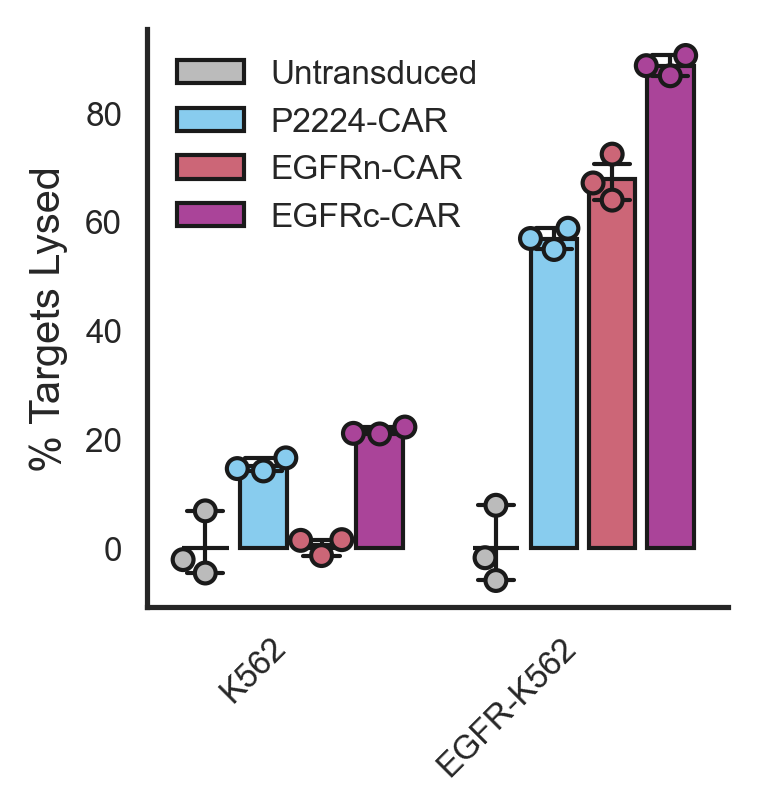

In [122]:
# with sns.color_palette([grey, "#0077bb", "#ee7733", "#cc3311"]):
with sns.color_palette([grey, "#88ccee", "#cc6677", "#aa4499"]):
    fig, ax = plt.subplots(1,1,figsize=(2.5,2.5), dpi=300)
    g = sns.swarmplot(data=count_df[(count_df['Ratio']=='1:1') &
                                      (count_df['Effector'].isin(effectors))],
                      x='Target', y='Lysis', hue='Effector',
                  order=targets,
                  hue_order=effectors, 
                  edgecolor='k', linewidth=1, dodge=True)
    sns.barplot(data=count_df[(count_df['Ratio']=='1:1') &
                                      (count_df['Effector'].isin(effectors))],
                      x='Target', y='Lysis', hue='Effector',
                  order=targets,
                  hue_order=effectors,
                estimator='mean', 
            dodge=True, edgecolor='k', capsize=0.5, gap=0.2, saturation=1,
            err_kws={'linewidth': 1, 'color':'k'})
    g.legend().remove()
    handles, labels = ax.get_legend_handles_labels()
    order = [4,5,6,7]
    plt.legend([handles[idx] for idx in order],
               [labels[idx] for idx in order],
               frameon=False, loc='upper left')
    g.set_ylabel('% Targets Lysed')
    g.set_xlabel('')
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.savefig(outputdir+'egfr-killing.pdf', bbox_inches='tight')

/opt/homebrew/Caskroom/miniforge/base/envs/flow/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/flow/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/flow/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/flow/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small e

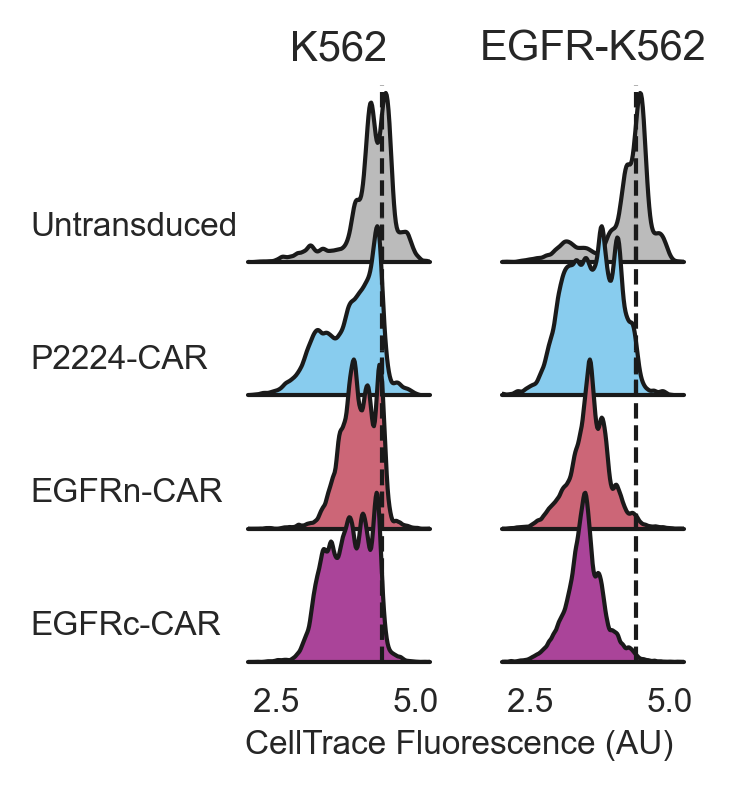

In [123]:
with sns.color_palette([grey, "#88ccee", "#cc6677", "#aa4499"]):
    g = sns.FacetGrid(data=df2[(df2['Type']=='Effector') &
                               (df2['Ratio']=='1:1') &
                               ~(df2['Effector']=='None')], 
                      row = 'Effector', col='Target', hue='Effector', sharey=False, aspect=1.5, height=0.625, xlim=[2, 5.25],
                      row_order=effectors, col_order=targets, hue_order=effectors, margin_titles=True)
    g.map(sns.kdeplot, "logFITC-A", fill=True, alpha=1, bw_adjust=0.5, clip=(2, 5.25), lw=0)
    g.map(sns.kdeplot, "logFITC-A", color="k", lw=1, bw_adjust=.5, clip=(2, 5.25))
    g.map(plt.axhline, y=0, lw=1, color='k', clip_on=False)
    g.map(plt.axvline, x=4.4, lw=1, linestyle='dashed', color='k', clip_on=False)

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.25, wspace=0.4)

    for ax in g.axes.flat:
        ax.set(facecolor=(0, 0, 0, 0))
        
    for ax, effector in zip(g.axes[:, 0], effectors):
        ax.text(-1.2,0.2, effector, ha="left", va="center", transform=ax.transAxes)

    # Remove axes details that don't play well with overlap
    g.set_titles(col_template="{col_name}", row_template="")
    g.set_axis_labels(y_var="", x_var="")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    g.axes[0,0].text(0.5, 0, "CellTrace Fluorescence (AU)", ha="center", va="center", transform=g.fig.transFigure)
    g.fig.set_dpi(300)
    plt.savefig(outputdir+'egfr-proliferation.pdf', bbox_inches='tight')

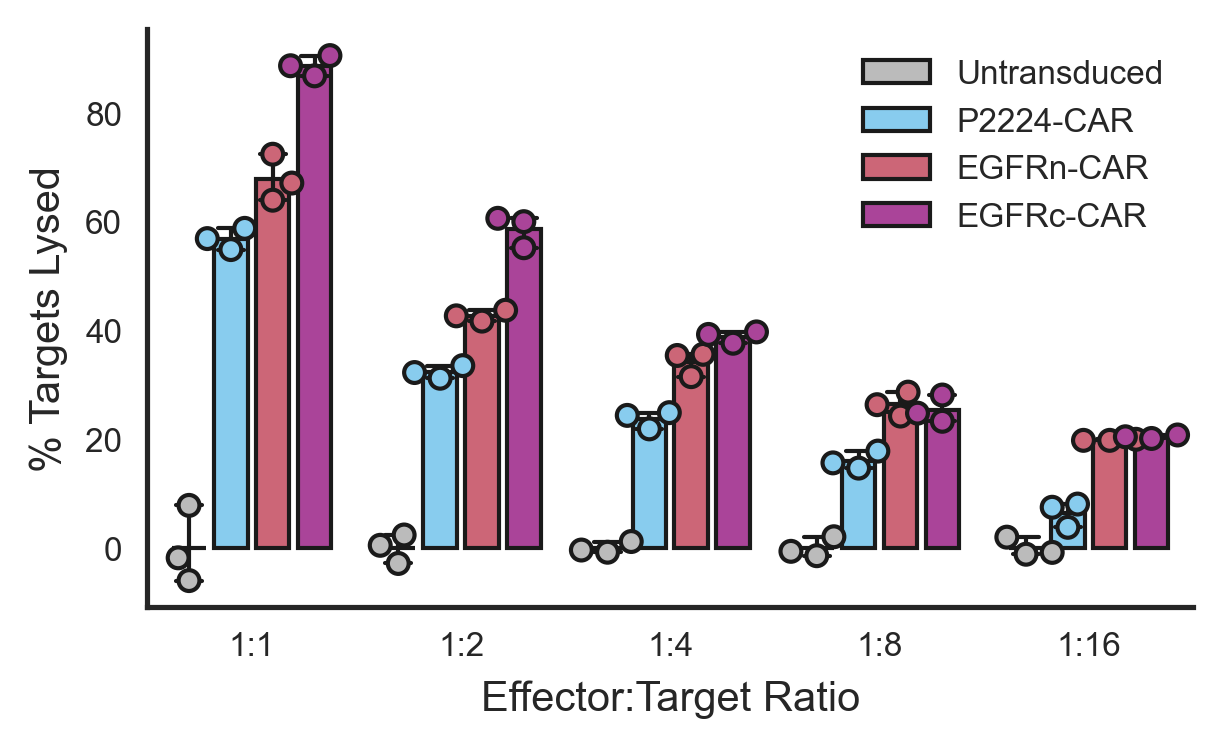

In [124]:
with sns.color_palette([grey, "#88ccee", "#cc6677", "#aa4499"]):
    fig, ax = plt.subplots(1,1,figsize=(4.5,2.5), dpi=300)
    g = sns.swarmplot(data=count_df[(count_df['Target']=='EGFR-K562') &
                                      (count_df['Effector'].isin(effectors))],
                      x='Ratio', y='Lysis', hue='Effector',
                  order=ratios,
                  hue_order=effectors, 
                  edgecolor='k', linewidth=1, dodge=True)
    sns.barplot(data=count_df[(count_df['Target']=='EGFR-K562') &
                                      (count_df['Effector'].isin(effectors))],
                      x='Ratio', y='Lysis', hue='Effector',
                  order=ratios,
                  hue_order=effectors,
                estimator='mean', 
            dodge=True, edgecolor='k', capsize=0.5, gap=0.2, saturation=1,
            err_kws={'linewidth': 1, 'color':'k'})
    g.legend().remove()
    handles, labels = ax.get_legend_handles_labels()
    order = [4,5,6,7]
    plt.legend([handles[idx] for idx in order],
               [labels[idx] for idx in order],
               frameon=False, loc='upper right')
    g.set_ylabel('% Targets Lysed')
    g.set_xlabel('Effector:Target Ratio')
    sns.despine()
    plt.savefig(outputdir+'egfr-etot.pdf', bbox_inches='tight')

Text(-0.05, 0.95, 'Effector:Target\nRatio')

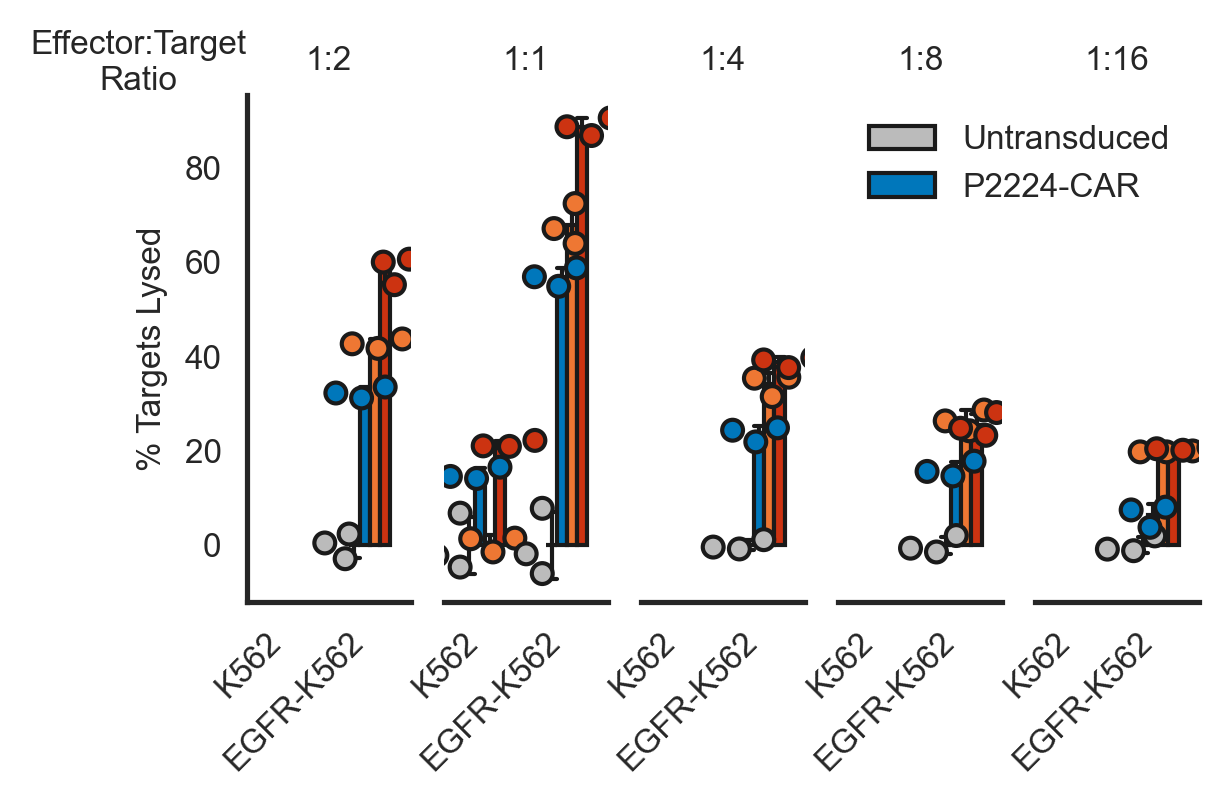

In [110]:
pal = [grey, "#0077bb", "#ee7733", "#cc3311"]
g = sns.catplot(kind='swarm', data=count_df[(count_df['Ratio'].isin(ratios)) &
                                (count_df['Effector'].isin(effectors))],
                col='Ratio', hue='Effector', aspect=0.4, x='Target', y='Lysis', palette=pal,
                order=targets, hue_order=effectors, edgecolor='k', linewidth=1, dodge=True)
g.map_dataframe(sns.barplot, x='Target', y='Lysis', order=targets,
                hue_order=effectors, errorbar='sd', hue='Effector',palette=pal,
                dodge=True, edgecolor='k', capsize=0.5, width=0.5, saturation=1,
                err_kws={'linewidth': 1, 'color':'k'})
g.figure.set_size_inches(3.8,2)
g.figure.set_dpi(300)
g.set_xlabels('')
g.set_xticklabels(rotation=45, ha='right', size=SMALL_SIZE)
g.fig.subplots_adjust(wspace=0.2)
g.set_titles(col_template='{col_name}', size=SMALL_SIZE)
g.legend.remove()
handles, labels = g.axes.flat[0].get_legend_handles_labels()
order = [0,1]
plt.legend([handles[idx] for idx in order],
           [labels[idx] for idx in order],
           frameon=False, loc='upper right')
for ax in g.axes.flat[1:]:
    ax.spines[['left']].set_visible(False)
g.set_ylabels('% Targets Lysed', size=SMALL_SIZE)
plt.figtext(-0.05, 0.95, 'Effector:Target\nRatio', size=SMALL_SIZE, horizontalalignment='center')
#plt.savefig(outputdir+'killing_init.pdf', bbox_inches='tight')

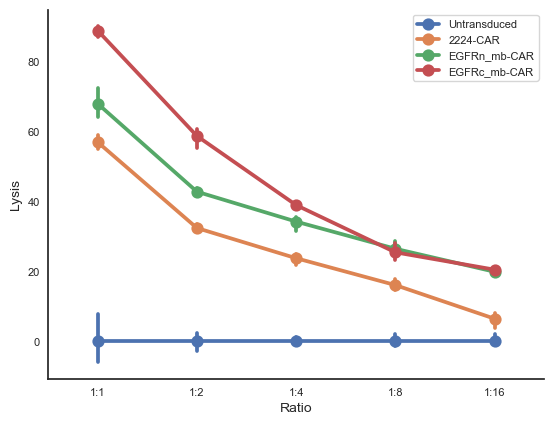

In [41]:
g = sns.pointplot(data=count_df[~(count_df.Target.isin(['None','K562']))], 
              x='Ratio', y='Lysis', hue='Effector',
              order=ratio_order,
              hue_order=effector_order)
g.legend().remove()
plt.legend(bbox_to_anchor=[1,1])
#plt.xticks(rotation=45, ha='right')
sns.despine()